## Setups

In [292]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets       # interactive display
from numpy.linalg import eigh
import imageio
from tqdm import tqdm
import IPython
from IPython.display import Image
# TODO add black
# TODO add matplotlib style

In [293]:
lambdas = np.array([1, 0.8, 0.5]).reshape((-1,1)) # shared noise spectrum
n = len(lambdas) # shared (latent) noise dimension
T = 300 # recorded datapoints

def set_true_ensambles(random_seed=0,N=20):
    np.random.seed(random_seed)
    C = np.clip(np.random.randn(N,n)**3,-1,1) # latent space projection
    # C[:2,1:] = 0
    # C[:2,0] = 1 # first two example neurons align with the PC0
    return C

def generate_data(C,random_seed=0,N=20):
    #generate synthetic data
    np.random.seed(random_seed)
    eps = np.random.randn(n,T) * lambdas # shared (latent) noise
    dx = 0.25*np.random.randn(N,T) # private single-neuron noise
    fr = 2.5*(np.random.rand(N).reshape((-1,1)) + 1) # avg fr in Hz
    dfr = np.random.rand(N).reshape((-1,1)) * 1 # fr changes in Hz
    z = (C @ eps + dx)
    x = z * dfr + fr

    return x.T

# set rois
all_rois = np.load('rois.npy')
np.random.seed(15) # a seed that looks nice
rois = all_rois[np.random.choice(np.arange(len(all_rois)),20)]

# set true ensambles
C = set_true_ensambles()

# generate and visualize the data
X = generate_data(C)
make_a_gif('Raw responses',
                '0_raw_fr.gif',
                X,
                rois,
                vmin=0,vmax=5)

100%|████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.72it/s]


In [294]:
def make_a_scene(dffs,roi_mask_list):
    scene = np.zeros(roi_mask_list[0].shape,dtype='float')
    for dff,roi in zip(dffs,roi_mask_list):
        scene += roi * dff
    return scene

def make_a_gif(title,gif_filename,data,rois,vmin=0,vmax=1):
    '''
    A function that makes a *.gif animation of neuronal population activity
    Parameters
    ----------
    title: TODO
    '''
    assert gif_filename[-4:] == '.gif'
    with imageio.get_writer(gif_filename, mode="I") as writer:

        for frame in tqdm(data):
            scene = make_a_scene(frame,rois)

            fig = plt.figure()
            plt.imshow(scene,cmap='gray',vmin=vmin,vmax=vmax)
            plt.axis('off')
            plt.title(title,fontsize=18)
            # label the neurons
            for i,roi in enumerate(rois):
                cm = np.array(np.where(roi)).mean(-1)[::-1]
                cm[0] += 10 # move right
                plt.text(*cm,i,color='white')
            filename = f"scene_{gif_filename[:-4]}.jpg"
            fig.savefig(filename)
            plt.close()
            image = imageio.imread(filename)
            writer.append_data(image)

# Intro: Large scale population recordings

TODO: add link to slides
![two model types](https://drive.google.com/uc?export=view&id=16G4HWvarW8rtNlBSlnCvCIcJq78Pr7Lu)


## How to make sense of these data?

In this tutorial, we will focus on the second class of models: the **latent variable** models. 
These models are useful for understanding modern single-unit recordings, which can have 100-1000-10000 of recorded neurons simultaneously. 

We will learn how to:
* visualize and perform exploration analysis on neuronal population data
* learn the difference between stimulus and noise correlations
* apply principle component analysis (PCA)
* understand the relationship between PCA and neuronal ensembles

# Exploratory data analysis

The first step of the analysis, when you get a new dataset, is to **visualize** what is in it. Let us start with a field-of-view video of neuronal activity (*note, this data resembles real, but it is not real; it was simulated for the sake of simplicity in this tutorial*)

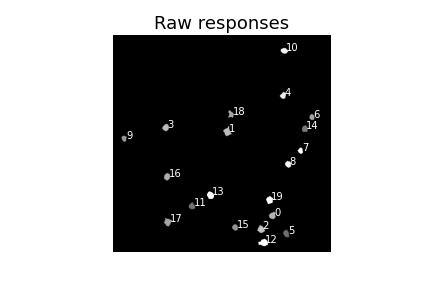

In [278]:
Image(filename='0_raw_fr.gif') # a simulated field-of-view recording for our dataset

Here we got our hands on a relatively small recording of neuronal activity in the visual cortex in response to a presentation of a stimulus (e.g. a picture of a Table Mountain). The responses were characterized by the average firing rate of each neuron in response to the stimulus and stored in the dataset $X$.
The dimensionality of the dataset $X$ is $[\mathrm{trials} \times \mathrm{neurons}]$

In [289]:
n_trials, n_neurons = X.shape
(n_trials, n_neurons)

(300, 20)

Note, that our simulated responses are non-negative. It is a common property both for the firing rate and the $\Delta F/F$ (with a properly subtracted baseline). Let's double-check that:

In [290]:
np.all(X>0)

False

We can also 'forget' about the locations of the neurons in the virtual field-of-view and visualize the data as it is, using a 2D raster plot:

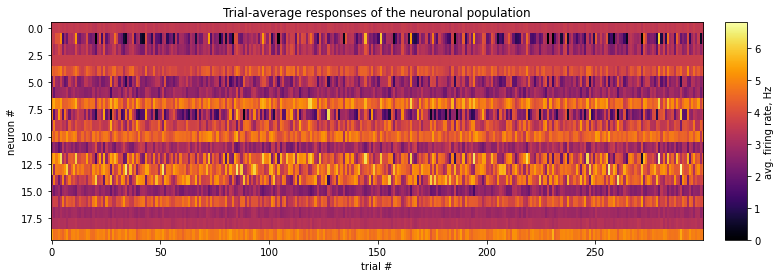

In [291]:
plt.figure(figsize=(20,4))
plt.imshow(X.T,vmin=0,aspect=5,interpolation='None',cmap='inferno')
plt.title('Trial-average responses of the neuronal population')
plt.xlabel('trial #')
plt.ylabel('neuron #')
plt.colorbar(aspect=10, pad=0.02,label='avg. firing rate, Hz')
# help(plt.colorbar)

### **Think!**

Is there any structure in the data? What does it tell us? Which neurons do you think work together?

Why do we see that rows on average have different colors?

1. There is some structure in those reponses... some rows in the 2D raster look similar, meaning that the neurons work together in sync!

2. **But**, we also see that rows on average have very different colors, meaning that the firing rates of the neurons are drastically different

## Focus on trial-to-trial variability

It is hard to tell what each neuron is doing from the visualizations above.

The reason for that is the variability in the individual properties of single neurons: their *mean* firing rates and the *trial-to-trial variability* in the single neuron responses.


### Exercise 1a: Calculate mean and std of the firing rate 
*Hint: think about the axes in the data. Which one is the sample-axis, and which one is the feature-axis?*

*Hint2: what dimensionality do we expect to see in the correct answer?*

Text(0, 0.5, 'firing rate, Hz')

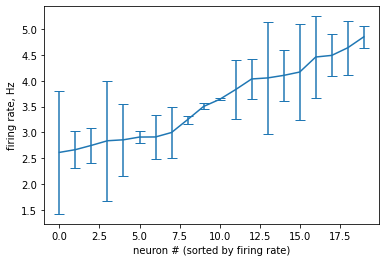

In [356]:
mean_fr = X.mean(0) # TODO: remove solution
std_fr = X.std(0) 

sort = np.argsort(mean_fr) # the ordering that sorts neuons according to their firing rate
plt.errorbar(range(len(mean_fr)),mean_fr[sort],yerr=std_fr[sort],capsize=5)
plt.xlabel('neuron # (sorted by firing rate)')
plt.ylabel('firing rate, Hz')

Remember, in this tutorial we are interested in the **neuronal population**: how individual neurons talk to each other and collectively process information.

Let us remove it by z-scoring the responses. *Z-scoring means subtracting the mean and dividing by the standard deviation (which we already calculated above).*

### Exercise 1b: Z-score the data

100%|████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.66it/s]


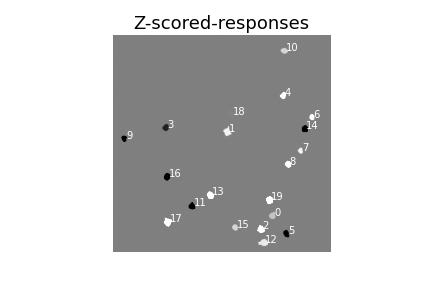

In [283]:
Z_scored_X = (X - mean_fr) / std_fr # TODO: remove solution

make_a_gif('Z-scored-responses','1_z-scored.gif',
           Z_scored_X,
           rois,
           vmin=-1,vmax=1)
Image(filename='1_z-scored.gif')

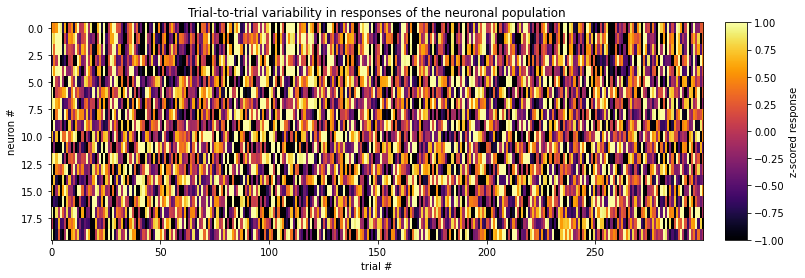

In [284]:
plt.figure(figsize=(20,4))
plt.imshow(Z_scored_X.T,vmin=-1,vmax=1,aspect=5,interpolation='None',cmap='inferno')
plt.title('Trial-to-trial variability in responses of the neuronal population')
plt.xlabel('trial #')
plt.ylabel('neuron #')
plt.colorbar(aspect=10, pad=0.02,label='z-scored response')
# help(plt.colorbar)

### **Think!**

Based on the video and 2D raster plot above, can you tell which neurons might be working together?

### Exercise 2: Find neurons that work in sync
Inform your guess based on the above visualization of the trial-to-trial variability.

Text(0, 0.5, 'activity of neuron #2, Hz')

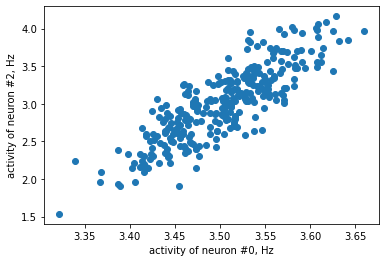

In [303]:
n1,n2 = 0, 2 # TODO: remove solution
data_pair = X[:,[n1,n2]] # taking a subset of 2 neurons from the population recording
plt.scatter(*data_pair.T)
plt.xlabel(f'activity of neuron #{n1}, Hz')
plt.ylabel(f'activity of neuron #{n2}, Hz')

If you indeed selected a *correlated* pair of neurons (such as #0 and #2), you would see that whenever the activity of the first one is high (low), the activity of the other one is also high (low). They generally tend to fire together!

## Describing joint neuronal activity with a multivariate Gaussian

TODO: download all images

The joint distribution of activity of these 2 neurons resemble a multivariate Gaussian, which typically looks like this:
![multivariate gaussian from wiki](https://drive.google.com/uc?export=view&id=1MFTd71NlwnxxLlPx0bcGMb4MLpoNrJ_h)

A multivariate N-dimensional Gaussian is characterized by 2 sets of parameters:
* the mean $\mathbf{\mu}$ (a $[N]$-dimensional vector)
* the covariance $\Sigma$ (an $[N \times N]$ matrix)

One of the simplest ways to fit the Gaussian distribution to the data is *via* so-called **moment-matching**: calculating means, variances and co-variances of the datapoints.

First we'll calculate the mean $\mathbf{\mu} = \mathop{\mathbb{E}}\mathbf{x} = \sum_{i=1}^n \mathbf{x}_i \, /\, n_\mathrm{trials} $ (a 2D vector for 2 neurons)

### Exercise 3a: Compute mean responses for each neuron

In [304]:
mu = data_pair.mean(0) # TODO: remove solution
mu

array([3.50256114, 2.99806111])

### Exercise 3b: Compute the covariance between activities of these neurons

Next, we calculate the covariance matrix for these neurons $\Sigma = \mathop{\mathbb{E}} (\mathbf{x}-\mathbf{\mu})^2 = \sum_{i=1}^n (\mathbf{x}_i - \mathbf{\mu})^T(\mathbf{x}_i - \mathbf{\mu})\, /\, n_\mathrm{trials}$

In [357]:
cov = (x-mu).T @ (x-mu) / n_trials #TODO: remove solution
cov

array([[0.00341004, 0.02414027],
       [0.02414027, 0.23949791]])

# WHITEBOARD recap of eigenvalue decomposition

TODO: write motivation

In [350]:
w,v = eigh(cov)
(w,v)

(array([0.00096695, 0.241941  ]),
 array([[-0.99491789,  0.10068959],
        [ 0.10068959,  0.99491789]]))

(-1.5, 1.5)

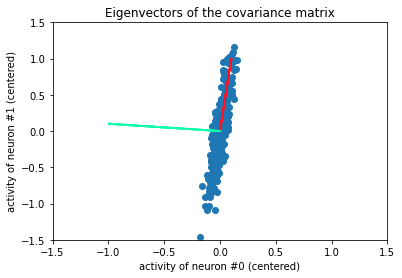

In [353]:
plt.scatter(*(x-mu).T) # here we subtract the mean (center the data)
plt.arrow(0,0,*(v[np.argmax(w)]),color='#FF1122',linewidth=2, label='First eigenvector (high eigenvalue)')
plt.arrow(0,0,*(v[np.argmin(w)]),color='#11FFAA',linewidth=2, label='Second eigenvector')
plt.xlabel('activity of neuron #0 (centered)')
plt.ylabel('activity of neuron #1 (centered)')
plt.title('Eigenvectors of the covariance matrix')
r=1.5 # plot range
plt.xlim([-r,r])
plt.ylim([-r,r])

### **Think!**

Suppose we want to reduce the dimensionality of this data from 2D -> 1D. Which direction is the most informative about the activity of both neurons?

## Projecting the activity on eigenvectors

# Principle component analysis (PCA)

## Step-by-step

Let us return to our larger, 20D z-scored dataset:

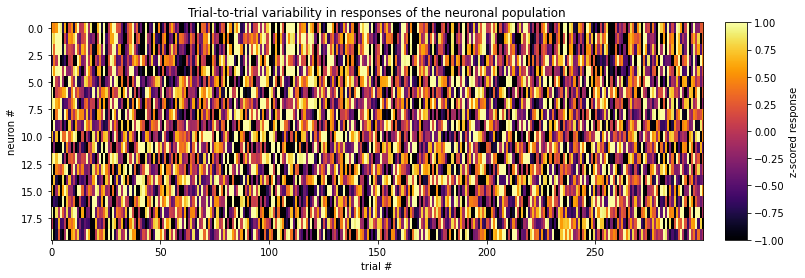

In [354]:
plt.figure(figsize=(20,4))
plt.imshow(Z_scored_X.T,vmin=-1,vmax=1,aspect=5,interpolation='None',cmap='inferno')
plt.title('Trial-to-trial variability in responses of the neuronal population')
plt.xlabel('trial #')
plt.ylabel('neuron #')
plt.colorbar(aspect=10, pad=0.02,label='z-scored response')
# help(plt.colorbar)

### **Exercise X**

Compute the covariance

$$X X^T$$

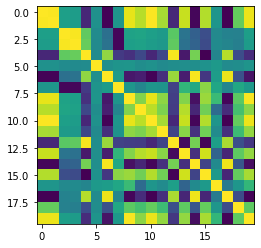

In [67]:
cov = z_scored_x.T @ z_scored_x / T

plt.imshow(cov)

Text(0, 0.5, 'eigenvalue')

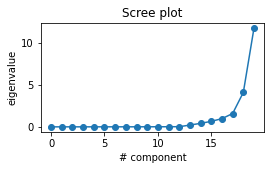

In [68]:
w,v = eigh(cov)

plt.figure(figsize=(4,2))
plt.plot(w)
plt.scatter(np.arange(len(w)),w)
plt.title('Scree plot')
plt.xlabel('# component')
plt.ylabel('eigenvalue')

Identifying population vectors

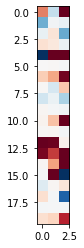

In [69]:
plt.imshow(v[:,:3],vmin=-.3,vmax=+.3,cmap='RdBu')

Identifying ensambles (TODO: ask Tom for a link)

## Using *sklearn*

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pcs = pca.fit_transform(z_scored_x) # TODO: set a trap for non-z-scored data
pcs.shape

(500, 3)

In [71]:
pca.singular_values_

array([76.89102673, 45.41850485, 28.29102173])

In [72]:
pca.explained_variance_ratio_

array([0.591223  , 0.20628406, 0.08003819])

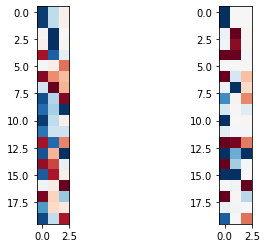

In [73]:
fig,ax=plt.subplots(1,2)
ax[0].imshow(pca.components_.T,vmin=-.3,vmax=+.3,cmap='RdBu')
ax[1].imshow(C,vmin=-1,vmax=+1,cmap='RdBu')

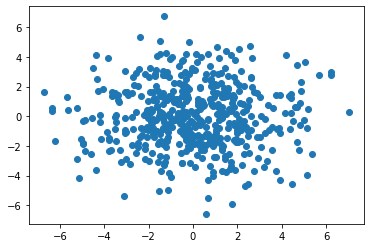

In [36]:
plt.scatter(*pcs[:,[0,1]].T)

Notes from NMS:
1. terms: orthonormal bases, changing bases, and correlation


# Conclusion

In this tutorial we:
* explored how to act when you encounter a new dataset (visualize!)
* learned how to disentangle stimulus from noise correlations
* learned the ideas and math behind the principle component analysis (PCA)
* applied PCA and successfully reconstructed the network connectivity

Let us now take a break and then discuss the limitations of our analysis. When does it work? When it does not? Let's find out! TODO: inseart mr peanutbutter

# Move to Dynamics

At the same time, it was shown that neural population activity often has a low-dimensional structure: a low number of latent dynamical factors can explain a large fraction of neural variability. This finding is called a *'manifold hypothesis'*, and was proposed in [Vyas et al. 2020](#references).

# Mini-projects

1. *Synthetic neuronal ensambles*
Generate your own neuronal network. Apply PCA, reconstruct neuronal activity

2. Allen Brain data analysis (starter notebook provided; result -- high risk)
Calculate noise correlations during visual stimulus presentations on Allen Brain data. Using PCA, identify the ensambles in the neuronal population, which work together. 
 TODO: Ask Tom for an ensemble link

3. *Merging dynamics with PCA* (based on Parts 1 & 2)
Generate observations from a linear dynamical model. 